# Imports

In [2]:
!pip install sklearn-crfsuite
!pip install git+https://github.com/lucasb-eyer/pydensecrf

  Cloning https://github.com/lucasb-eyer/pydensecrf to /tmp/pip-req-build-_ukcm474
  Running command git clone --filter=blob:none --quiet https://github.com/lucasb-eyer/pydensecrf /tmp/pip-req-build-_ukcm474
  Resolved https://github.com/lucasb-eyer/pydensecrf to commit 2723c7fa4f2ead16ae1ce3d8afe977724bb8f87f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [23]:
import os
import cv2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from tqdm.auto import tqdm
from google.colab import drive
from sklearn_crfsuite import CRF
from skimage.color import label2rgb
from pydensecrf import densecrf as dcrf
from skimage.segmentation import slic, mark_boundaries
from pydensecrf.utils import unary_from_labels, create_pairwise_gaussian, create_pairwise_bilateral

# Connecting to the Google Drive Shortcuts


Before you run the cells bellow, make sure to make a google drive short cut to the [DBL Google Drive](https://drive.google.com/drive/u/0/folders/1JWr9SORKKmUjwQFYigekfVXpHwfEqNss)

In [4]:
ROOT_PATH = '/content/drive/MyDrive/jbg060_AI_for_Good_course_Shared'
drive.mount('/content/drive')

Mounted at /content/drive


# Global variables

In [5]:
# Original data and annotations path
DATA_BASE_PATH = os.path.join(ROOT_PATH, '01_Data', 'benthic_datasets', 'point_labels', 'SEAVIEW')
ANNOTATIONS_PATH = os.path.join(DATA_BASE_PATH, 'tabular-data')

In [6]:
REGIONS = {
    1: 'ATL', 2: 'IND_CHA', 3: 'IND_MDV', 4: 'PAC_AUS', 5: 'PAC_USA',
    6: 'PAC_IDN_PHL', 7: 'PAC_SLB', 8: 'PAC_TWN', 9: 'PAC_TLS',
    }
IMAGE_COUNTS = {
    1: 1407, 2: 686, 3: 1612, 4: 2657, 5: 1153,
    6: 1638, 7: 732, 8: 638, 9: 864,
    }
POINT_COUNTS = {
    1: 92900, 2: 52450, 3: 144100, 4: 186420, 5: 83100,
    6: 120100, 7: 59200, 8: 50000, 9: 71600,
    }

In [7]:
# initialize a data frame to hold the annotations across all regions
ANNOTATIONS_DF = pd.DataFrame()

# read individual region specific annotations file and append to main data frame
# region speicific annotation files contain additional useful columns

# loop through the list of regions
for region in tqdm(REGIONS.values(), total=len(REGIONS)):

    # read region specific annotation file
    region_wise_annotations_df = \
        pd.read_csv(
            os.path.join(ANNOTATIONS_PATH, f"annotations_{region}.csv"),
            header='infer',
        )

    # assign region name under to which image files belong to
    region_wise_annotations_df['region'] = region

    # append to main annotations data frame
    ANNOTATIONS_DF = \
        pd.concat(
            [ANNOTATIONS_DF, region_wise_annotations_df],
            ignore_index=True,
            )

ANNOTATIONS_DF['func_group_alt'] = \
    [func_group if func_group in ('Hard Coral', 'Soft Coral') else 'Others'
     for func_group in ANNOTATIONS_DF.func_group]

region_wise_annotations_df.head()

  0%|          | 0/9 [00:00<?, ?it/s]

quadratid    y    x                                         label_name  \
0  30002121501   83   85                              Loose Substrate: Sand   
1  30002121501   93  319                              Loose Substrate: Sand   
2  30002121501  128  457  Other soft-corals no common Alcyoniidae and er...   
3  30002121501  245  578  Other soft-corals no common Alcyoniidae and er...   
4  30002121501  163  670  Other soft-corals no common Alcyoniidae and er...   

        label  func_group  method data_set   region  
0   LSUB_SAND       Other  random    train  PAC_TLS  
1   LSUB_SAND       Other  random     test  PAC_TLS  
2  SINV_SFC_O  Soft Coral  random     test  PAC_TLS  
3  SINV_SFC_O  Soft Coral  random     test  PAC_TLS  
4  SINV_SFC_O  Soft Coral  random     test  PAC_TLS

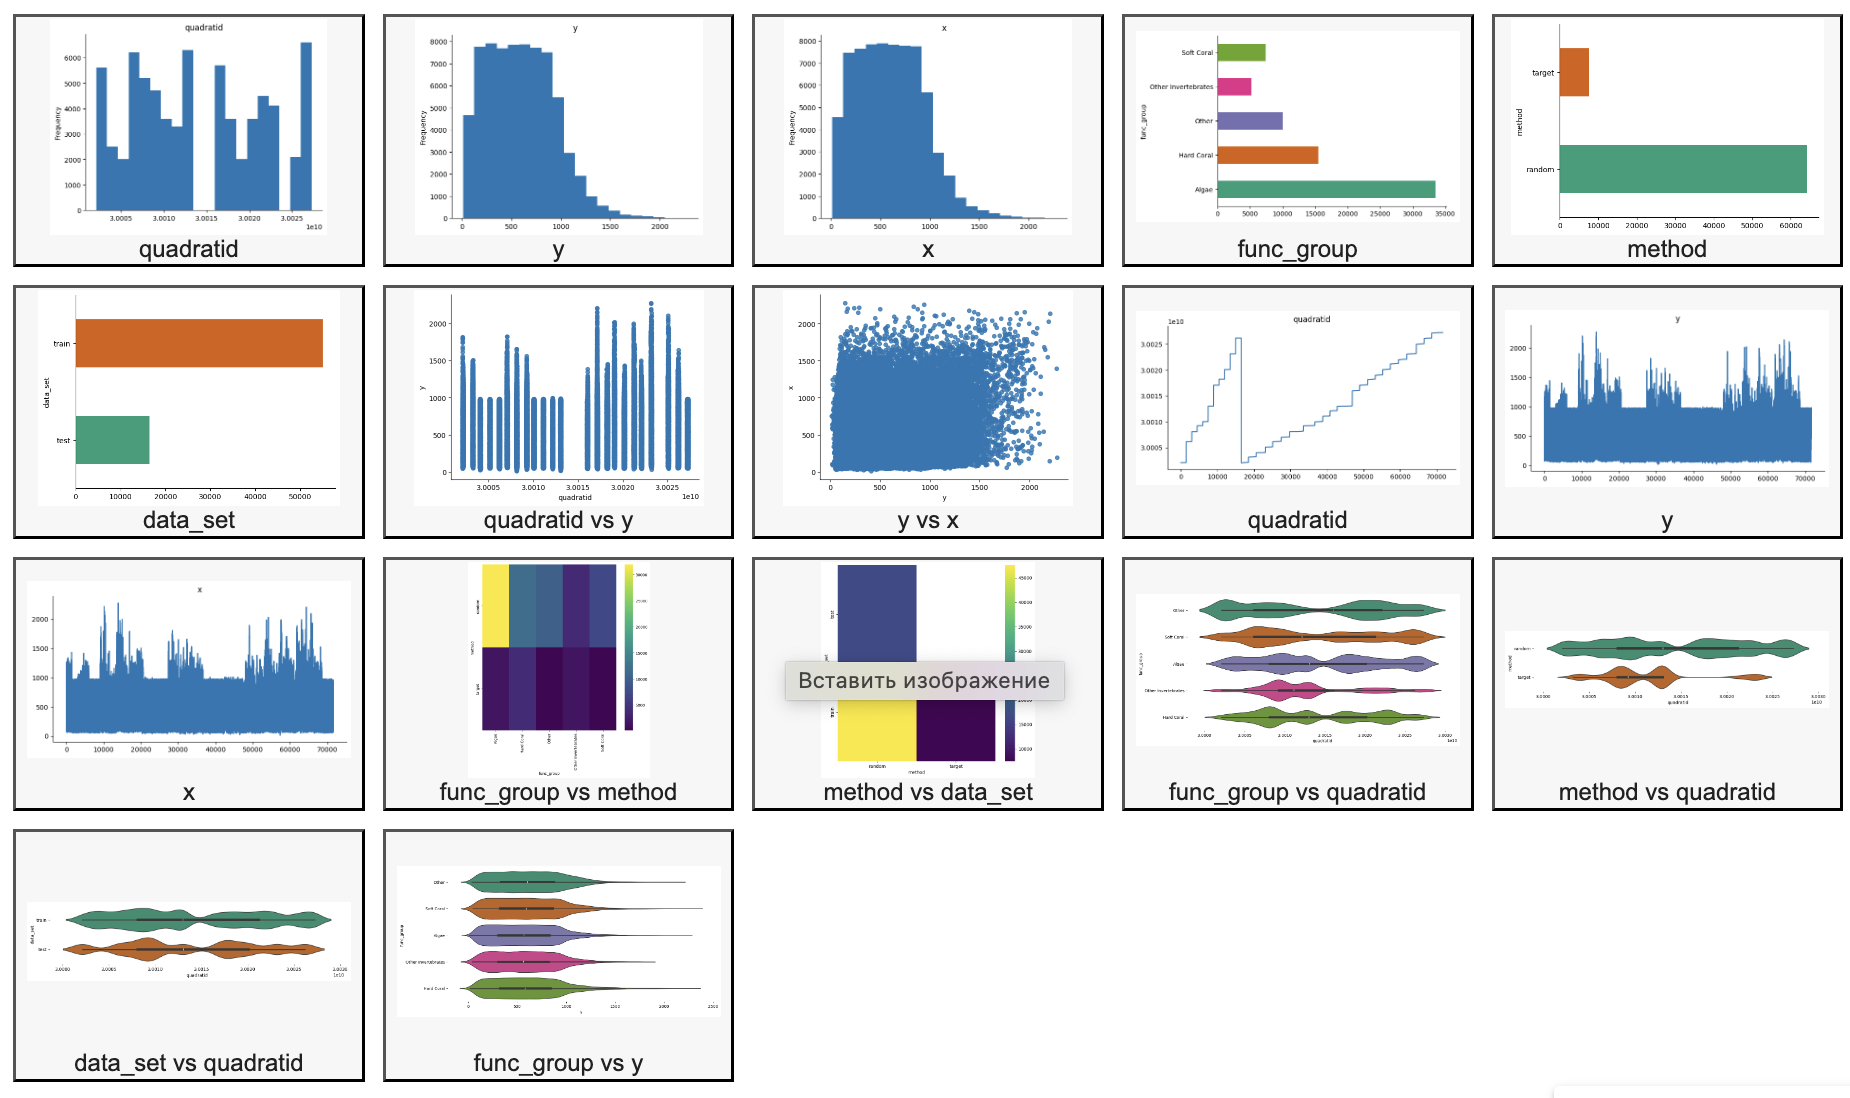

In [8]:
ANNOTATIONS_DF.head()

quadratid    y    x label_name label  func_group  method data_set region  \
0  17001738002  180  183       Fish  FISH       Other  random     test    ATL   
1  17001738002  199  162        CCA   CCA       Algae  random     test    ATL   
2  17001738002  197  160        CCA   CCA       Algae  random     test    ATL   
3  17001738002   88  561       Turf  Turf       Algae  random     test    ATL   
4  17001738002  195  714   Ocomplex  OCOM  Hard Coral  random     test    ATL   

  func_group_alt  
0         Others  
1         Others  
2         Others  
3         Others  
4     Hard Coral

In [9]:
sum_unique_quadrats = 0
all_image_files = []
for key, folder in REGIONS.items():
    image_files = os.listdir(os.path.join(DATA_BASE_PATH, folder))
    annotation_quadrats = set(ANNOTATIONS_DF.query(f"region == '{folder}'")\
                                            .quadratid\
                                            .astype('str')\
                                            +'.jpg')
    sum_unique_quadrats += len(annotation_quadrats)
    all_image_files = set(all_image_files) | set(image_files)

    print("-"*80)
    print(f"{folder}: ")
    print(f"\t # of Image Files = {len(image_files)}")
    print(f"\t # of Unique Image Files = {len(set(image_files))}")
    print(f"\t # of Unique Quadrats in Annotations = {len(annotation_quadrats)}")
    print(f"\t # of Images as per Dataset Summary = {IMAGE_COUNTS[key]}")
    print(f"\t Intersection of Folder & Annotations = {len(set(image_files) & annotation_quadrats)}")
    print(f"\t Annotations MINUS Folder = {len(annotation_quadrats - set(image_files))}, {annotation_quadrats - set(image_files)}")
    print(f"\t Folder MINUS Annotations = {len(set(image_files) - annotation_quadrats)}, {set(image_files) - annotation_quadrats}")

print("-"*80)

print(f"# of Unique Quadrat IDs across regions = {ANNOTATIONS_DF.quadratid.nunique()}")
print(f"# of Unique Quadrat IDs across all folder = {len(all_image_files)}")
print(f"Sum of Unique Quadrat IDs within each folder = {sum_unique_quadrats}")

for key, folder in REGIONS.items():
    annotations_count = ANNOTATIONS_DF.query(f"region == '{folder}'").shape[0]

    # Unique count based on ['quadratid', 'x', 'y']
    unique_count_1 = ANNOTATIONS_DF.query(f"region == '{folder}'")\
                                   .groupby(['quadratid', 'x', 'y'])\
                                   .size()\
                                   .reset_index(name='count')\
                                   .query('count == 1')\
                                   ['count']\
                                   .count()

    # Unique count based on ['quadratid', 'x', 'y', 'label']
    unique_count_2 = ANNOTATIONS_DF.query(f"region == '{folder}'")\
                                   .groupby(['quadratid', 'x', 'y', 'label'])\
                                   .size()\
                                   .reset_index(name='count')\
                                   .query('count == 1')\
                                   ['count']\
                                   .count()

    # Print the results
    print("-"*80)
    print(f"{folder}: ")
    print(f"\t # of Points in Summary = {POINT_COUNTS[key]}")
    print(f"\t # of Points in Annotations File = {annotations_count}")
    print(f"\t # of Unique Points (Quadrat ID, X, Y) = {unique_count_1}")
    print(f"\t # of Unique Points (Quadrat ID, X, Y, Label) = {unique_count_2}")
    print(f"\t # of Contradictory Annotations for Same Point = {unique_count_2 - unique_count_1}")

print("-"*80)

--------------------------------------------------------------------------------
ATL: 
	 # of Image Files = 1407
	 # of Unique Image Files = 1407
	 # of Unique Quadrats in Annotations = 1407
	 # of Images as per Dataset Summary = 1407
	 Intersection of Folder & Annotations = 1407
	 Annotations MINUS Folder = 0, set()
	 Folder MINUS Annotations = 0, set()
--------------------------------------------------------------------------------
IND_CHA: 
	 # of Image Files = 686
	 # of Unique Image Files = 686
	 # of Unique Quadrats in Annotations = 686
	 # of Images as per Dataset Summary = 686
	 Intersection of Folder & Annotations = 686
	 Annotations MINUS Folder = 0, set()
	 Folder MINUS Annotations = 0, set()
--------------------------------------------------------------------------------
IND_MDV: 
	 # of Image Files = 1612
	 # of Unique Image Files = 1612
	 # of Unique Quadrats in Annotations = 1612
	 # of Images as per Dataset Summary = 1612
	 Intersection of Folder & Annotations = 1612
	 

In [10]:
ANNOTATIONS_DF

quadratid    y    x                                label_name  \
0       17001738002  180  183                                      Fish   
1       17001738002  199  162                                       CCA   
2       17001738002  197  160                                       CCA   
3       17001738002   88  561                                      Turf   
4       17001738002  195  714                                  Ocomplex   
...             ...  ...  ...                                       ...   
859865  30027261001  910  700  Epilithic algal matirx smotheting rubble   
859866  30027261001  905  933  Epilithic algal matirx smotheting rubble   
859867  30027261001  930  876  Epilithic algal matirx smotheting rubble   
859868  30027261001  826  884  Epilithic algal matirx smotheting rubble   
859869  30027261001  829  914  Other sesile invertebrates Bryozoa clams   

           label           func_group  method data_set   region func_group_alt  
0           FISH                Other  random     test      ATL         Others  
1            CCA                Algae  random     test      ATL         Others  
2            CCA                Algae  random     test      ATL         Others  
3           Turf                Algae  random     test      ATL         Others  
4           OCOM           Hard Coral  random     test      ATL     Hard Coral  
...          ...                  ...     ...      ...      ...            ...  
859865    EAM_RB                Algae  random    train  PAC_TLS         Others  
859866    EAM_RB                Algae  random    train  PAC_TLS         Others  
859867    EAM_RB                Algae  random    train  PAC_TLS         Others  
859868    EAM_RB                Algae  random    train  PAC_TLS         Others  
859869  SINV_OTH  Other Invertebrates  random    train  PAC_TLS         Others  

[859870 rows x 10 columns]

## Train Test Leakage Check

### Train Test Leakage Candidates

In order to avoid train-test leakage, it is important to ensure that the same image (photoquadrat) is not used in both train and test datasets.

In [11]:
ANNOTATIONS_DF\
    .groupby(['region', 'quadratid'])\
    .agg(DataSetUniqueCount=('data_set', 'nunique'))\
    .reset_index()\
    .query("DataSetUniqueCount > 1")\
    .groupby(['region'])\
    .agg(quadrat_count=('quadratid', 'count'))\
    .reset_index()

region  quadrat_count
0          ATL              2
1      IND_CHA              4
2      IND_MDV             53
3      PAC_AUS              3
4  PAC_IDN_PHL             13
5      PAC_SLB              7
6      PAC_TLS             14
7      PAC_TWN             12
8      PAC_USA              8

In [12]:
ANNOTATIONS_DF\
    .groupby(['quadratid', 'region', 'data_set'])\
    .agg(PointsCount=('quadratid', 'count'))\
    .reset_index()\
    .query(
        "quadratid == 24044096401"
    )

quadratid region data_set  PointsCount
3061  24044096401    ATL     test           50
3062  24044096401    ATL    train          100

In [13]:
train_test_leakage_candidates = \
    ANNOTATIONS_DF\
        .groupby(['quadratid'])\
        .agg(DataSetUniqueCount=('data_set', 'nunique'))\
        .reset_index()\
        .query("DataSetUniqueCount > 1")\
        .quadratid.to_list()

### Observations

* There is a possibility of train-test leakage in 116 images as some random point annotations belong to train dataset and remaining random point annotations belong to test dataset.
* The issue can be eliminated by excluding these 116 images from all datasets or they can be re-assigned to a single dataset as per below approach.

## Train Test Split - Alternate Criteria

Alternate Approach: Revise the train-test splits based on a different criteria (not recommended though)

### Quadrat ID Format

Each quardratid is 11 digits. The format is as follows:
1. First 5 digits = Survey ID. It is the unique identifier of each reef location in space and time.
2. First 9 digits = Image ID. This corresponds to the five-digit survey ID and four more digits between 0001 and 9999 (number of the picture automatically assigned by the camera). Identical image ID’s will appear multiple times in this field as one image has associated multiple quadrats.
3. Last 2 digits usually between 01 and 09 = Quadrat Number within an image. This is automatically assigned during the cropping process. This would imply that each image acquired by the camera may produce anywhere between 1 - 9 photo-quadrats (each of which cover 1$m^2$ coral/sea substrate footprint).

“.jpg” must be added to the quadrat ID to derive the filename of the quadrat (with the extension) within the imagery.

Hierarchical structure of photo-quadrat dataset is shown in the below figure. A transect refers to a location that can be surveyed multiple times (e.g. in different years). Each survey involves the collection of many images. From each image one or more standardised photo-quadrat images can be extracted.

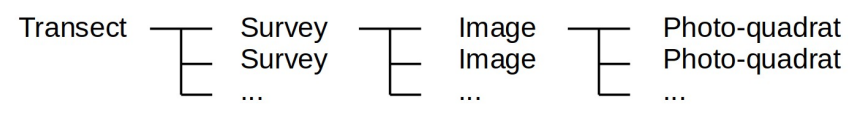

### Test Transect Selection Process

XL Catlin Seaview Survey project team selected testing dataset as a separate set of images from the training dataset to ensure complete independence from the data used to train the network models.

This test dataset was a selection of contiguous images within transects with an extent of 30 m in length, concomitant with most coral reef monitoring programs and best represents the spatial heterogeneity within a site. Therefore, they aggregated the images from the 2 km transects within a standard transect length of 30 m, hereafter called “test transects”. Test transects were selected at random, within the 2 km transects, while ensuring that no test transect contained images used for training the networks [3].

To locate the 30m units (test transects) within the 2km-transects, they used images for all surveyed years in each transect and applied hierarchical clustering with Ward’s method, as implemented in the “hclust” function of R (https://www.mdpi.com/2072-4292/12/3/489/s1). The Ward’s method creates clusters that minimize within-cluster variance in the distance metric (the physical distance among points i.e. images) and cut the cluster at 30m to identify the aggregation groups. From these units, a number
test transects per region were selected at random.

### Selection Criteria from Data

The number of images and points manually annotated per network is presented in https://www.nature.com/articles/s41597-020-00698-6/tables/3. In general, random point annotations were done for about 100 points per photo-quadrat for training sets and 40 or 50 points per photo-quadrat for testing sets [1].

Based on the table referred above, it can be observed that 586,740 annotations were done for 5,801 training photo-quadrats. Moreover, 273,130 annotations were done for 5,747 photo-quadrats from 517 test transects. The average annotations per quadrat for training and test sets are 101.14 and 47.53 respectively.

**Possible Criteria:**

* Quadrats that contain 50 annotation points or less = test set
* Quadrats that contain at least 100 annotation points = training sets

Histogram showing the distribution of # of random point annotations per photoquadrat (image)

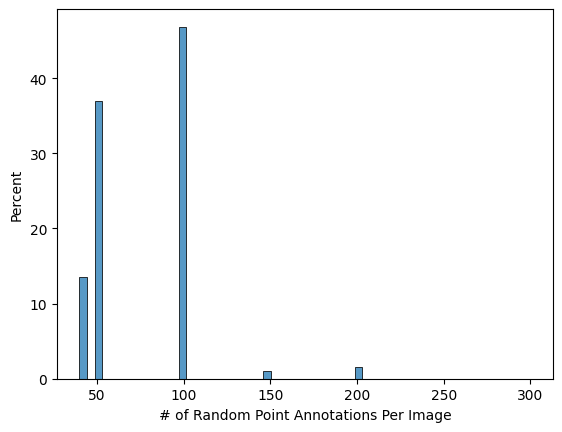

In [14]:
sns.histplot(
    data=ANNOTATIONS_DF\
            .groupby('quadratid')\
            .agg(points_count=('quadratid', 'count'))\
            .reset_index(),
    x='points_count',
    stat='percent',
    )
plt.xlabel("# of Random Point Annotations Per Image")
plt.show()

Frequency table for # of random point annotations per photoquadrat (image)

In [15]:
ANNOTATIONS_DF\
    .groupby(['quadratid'])\
    .agg(points_count=('quadratid', 'count'))\
    .reset_index()\
    .groupby(['points_count'])\
    .count()\
    .reset_index()

points_count  quadratid
0            40       1543
1            50       4209
2            80          1
3           100       5336
4           140          3
5           150        111
6           200        182
7           250          1
8           300          1

Region wise frequencies for # of random point annotations per photoquadrat (image)

In [16]:
ANNOTATIONS_DF\
    .groupby(['quadratid', 'region'])\
    .agg(points_count=('quadratid', 'count'))\
    .reset_index()\
    .groupby(['region', 'points_count'])\
    .agg(quadrats=('quadratid', 'count'))

quadrats
region      points_count          
ATL         50                 958
            100                447
            150                  2
IND_CHA     50                 327
            100                355
            150                  4
IND_MDV     50                 487
            100               1028
            150                 52
            200                 43
            250                  1
            300                  1
PAC_AUS     40                1543
            80                   1
            100                978
            140                  3
            200                132
PAC_IDN_PHL 50                 887
            100                738
            150                 13
PAC_SLB     50                 293
            100                429
            150                  7
            200                  3
PAC_TLS     50                 317
            100                530
            150                 13
            200                  4
PAC_TWN     50                 288
            100                338
            150                 12
PAC_USA     50                 652
            100                493
            150                  8

Check points_count pattern before excluding train-test leakage candidates

In [17]:
ANNOTATIONS_DF\
    .groupby(['quadratid', 'region', 'data_set'])\
    .agg(points_count=('quadratid', 'count'))\
    .reset_index()\
    .groupby(['region', 'data_set', 'points_count'])\
    .count()

quadratid
region      data_set points_count           
ATL         test     50                  960
            train    100                 449
IND_CHA     test     50                  331
            train    100                 359
IND_MDV     test     50                  540
            train    100                1080
                     200                  44
                     300                   1
PAC_AUS     test     40                 1425
                     80                    1
            train    40                  121
                     100                 981
                     200                 132
PAC_IDN_PHL test     50                  900
            train    100                 751
PAC_SLB     test     50                  300
            train    100                 436
                     200                   3
PAC_TLS     test     49                    1
                     50                  329
            train    1                     1
                     100                 543
                     200                   4
PAC_TWN     test     50                  300
            train    100                 350
PAC_USA     test     50                  660
            train    100                 501

Check points_count pattern after excluding train-test leakage candidates

In [18]:
ANNOTATIONS_DF\
    .query(f"~ quadratid.isin({train_test_leakage_candidates})")\
    .groupby(['quadratid', 'region', 'data_set'])\
    .agg(points_count=('quadratid', 'count'))\
    .reset_index()\
    .groupby(['region', 'data_set', 'points_count'])\
    .count()

quadratid
region      data_set points_count           
ATL         test     50                  958
            train    100                 447
IND_CHA     test     50                  327
            train    100                 355
IND_MDV     test     50                  487
            train    100                1028
                     200                  43
                     300                   1
PAC_AUS     test     40                 1422
                     80                    1
            train    40                  121
                     100                 978
                     200                 132
PAC_IDN_PHL test     50                  887
            train    100                 738
PAC_SLB     test     50                  293
            train    100                 429
                     200                   3
PAC_TLS     test     50                  316
            train    100                 530
                     200                   4
PAC_TWN     test     50                  288
            train    100                 338
PAC_USA     test     50                  652
            train    100                 493

### Observations

* Data indicates a clear pattern and it agrees with the description provided in the research paper.
* Quadrats that have 50 or 40 random point annotations can be treated as "Test Dataset".
* Quadrats that have 100 or more random points annotations can be treated as "Training Dataset".
* One quadrat contains 80 random point annotations - this can  be treated as "Training Dataset" or excluded from all datasets.

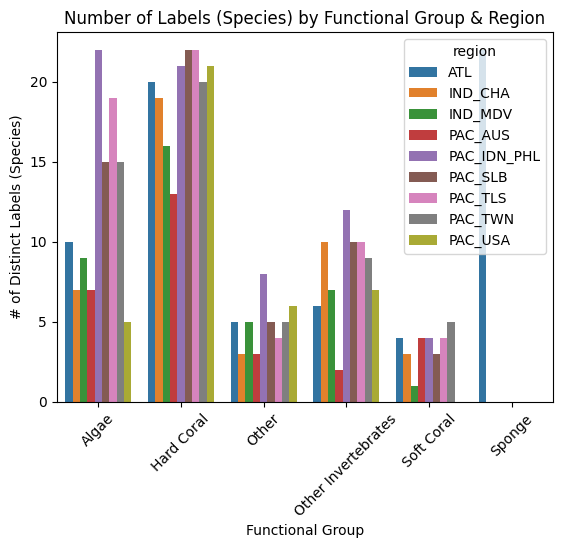

In [19]:
sns.barplot(
    data=ANNOTATIONS_DF\
            .groupby(['region', 'func_group'])\
            .agg(labels_count=('label_name', 'nunique'))\
            .reset_index(),
    x='func_group',
    y='labels_count',
    hue='region',
    )
plt.title("Number of Labels (Species) by Functional Group & Region")
plt.xlabel("Functional Group")
plt.ylabel("# of Distinct Labels (Species)")
plt.xticks(rotation=45)
plt.show()

# Load and View

Quadrat (Image) File Path: /content/drive/MyDrive/jbg060_AI_for_Good_course_Shared/01_Data/benthic_datasets/point_labels/SEAVIEW/ATL/17001652802.jpg


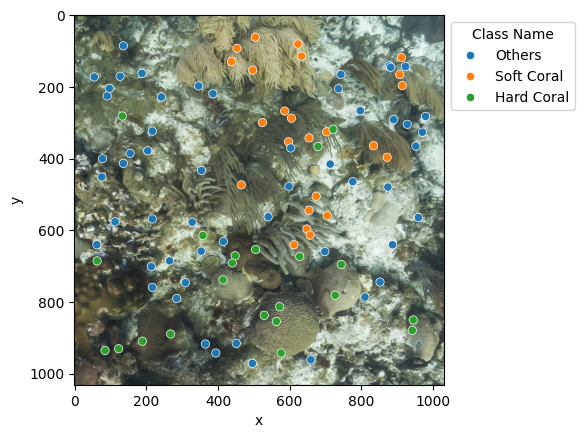

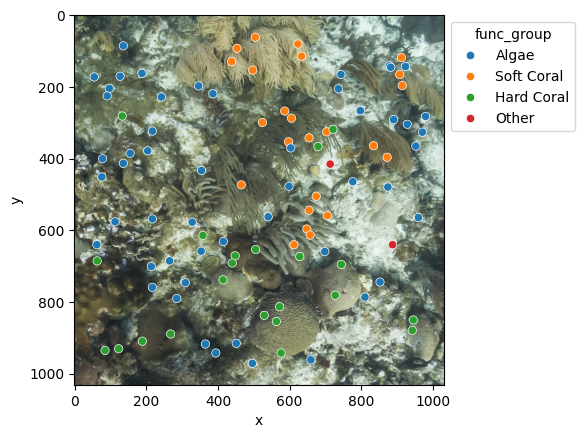

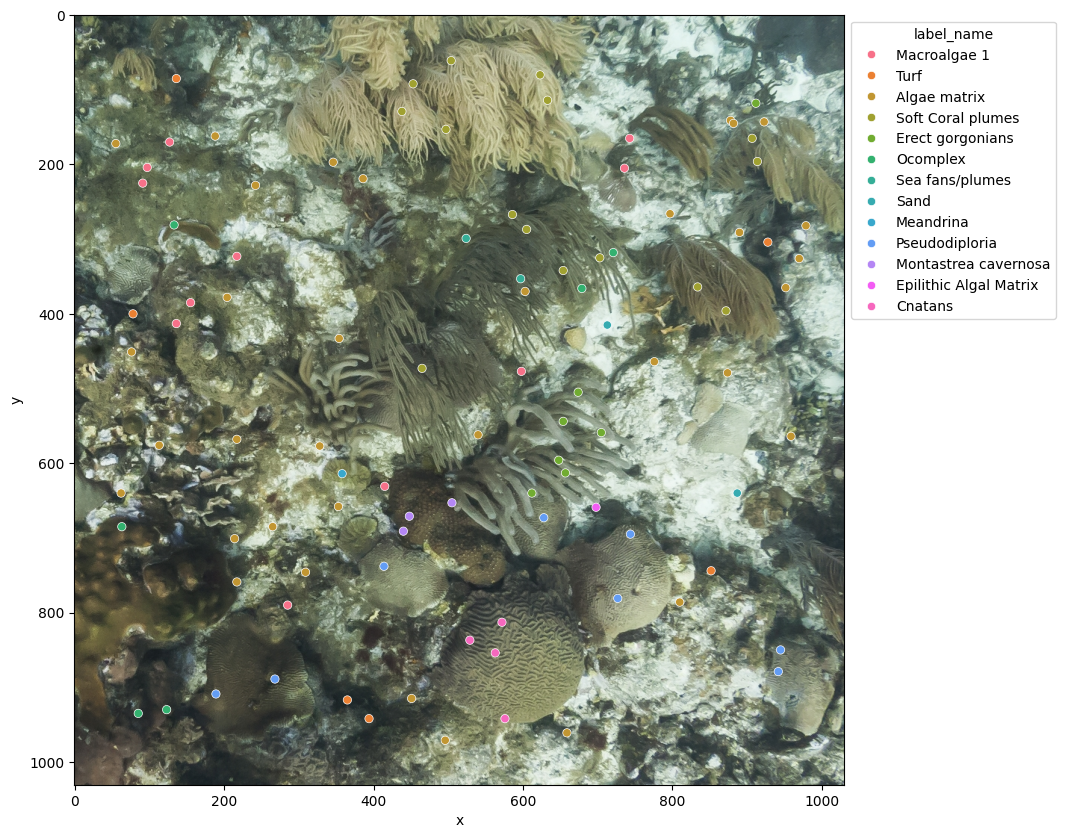

In [20]:
quadrat_id =  17001652802

quadrat_region = \
    ANNOTATIONS_DF[ANNOTATIONS_DF.quadratid == quadrat_id].region.to_list()[0]
quadrat_path = os.path.join(DATA_BASE_PATH, quadrat_region, f"{quadrat_id}.jpg")
quadrat_df = \
    ANNOTATIONS_DF\
        .query(f"quadratid == {quadrat_id}")\
        [['x', 'y', 'func_group', 'func_group_alt', 'label', 'label_name', 'data_set', 'method']]

if os.path.exists(quadrat_path):
    print(f"Quadrat (Image) File Path: {quadrat_path}")

quadrat_image = cv2.imread(quadrat_path)
quadrat_image = cv2.cvtColor(quadrat_image, cv2.COLOR_BGR2RGB)

plt.imshow(quadrat_image)
ax = sns.scatterplot(data=quadrat_df, x='x', y='y', hue='func_group_alt')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1), title='Class Name')
plt.show()

plt.imshow(quadrat_image)
ax = sns.scatterplot(data=quadrat_df, x='x', y='y', hue='func_group')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(quadrat_image)
ax = sns.scatterplot(data=quadrat_df, x='x', y='y', hue='label_name')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.show()

# Stage 1 - Preprocessing and Superpixel Segmentation (SLIC)

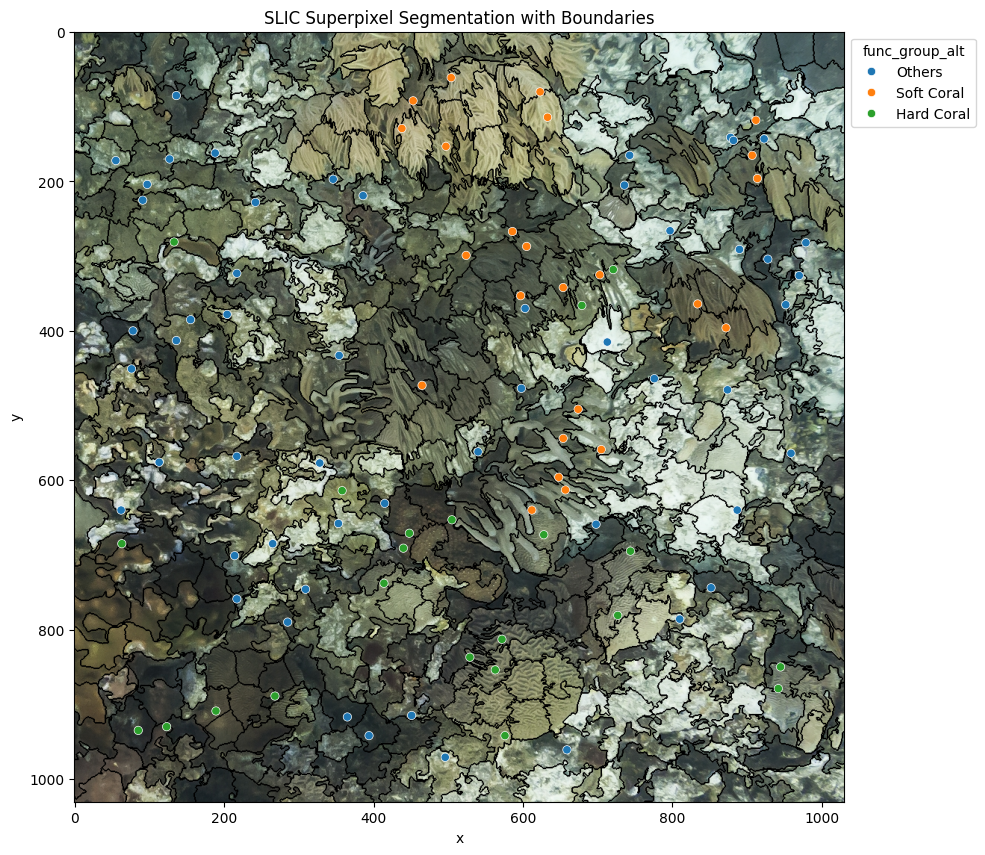

In [27]:
# Load image
image = cv2.imread(os.path.join(DATA_BASE_PATH, quadrat_region, f"{quadrat_id}.jpg"))
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply SLIC superpixel segmentation
num_segments = 600  # Number of desired superpixels
segments = slic(image_rgb, n_segments=num_segments, compactness=10, sigma=1)

# Visualize superpixels with boundaries only (no color filling)
segmented_image_with_boundaries = mark_boundaries(image_rgb, segments, color=(0, 0, 0), mode='inner')  # `color` sets the boundary color (white here)

# Plot the image with the superpixel boundaries
plt.figure(figsize=(10, 10))
plt.imshow(segmented_image_with_boundaries)
ax = sns.scatterplot(data=quadrat_df, x='x', y='y', hue='func_group_alt')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))
plt.title('SLIC Superpixel Segmentation with Boundaries')
plt.show()


# Step 2, Sparse Label Propagation after Superpixel Application (dev)

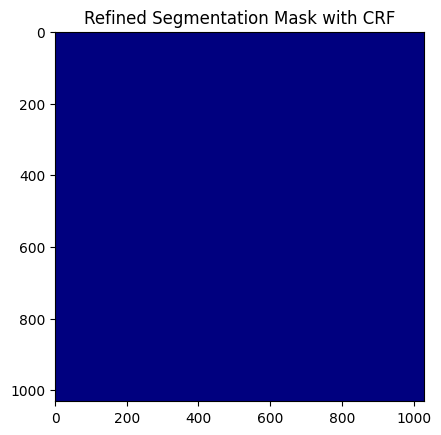

In [31]:
# Sparse label positions and corresponding labels
sparse_labels = {(int(row['y']), int(row['x'])): row['func_group_alt'] for _, row in quadrat_df.iterrows()}

# Create a mapping from string labels to integer labels
unique_labels = set(sparse_labels.values())
label_mapping = {label: idx for idx, label in enumerate(unique_labels)}

# Create the label map
height, width, _ = image_rgb.shape
label_map = np.full((height, width), -1)  # Default to -1 (unlabeled)

# Assign labels to the label map based on sparse labels
for (y_coord, x_coord), label in sparse_labels.items():
    label_map[y_coord, x_coord] = label_mapping[label]  # Convert string label to integer

def extract_features(image_rgb, segments):
    height, width, _ = image_rgb.shape
    features = np.zeros((height, width, 5))  # Example: 5 features per pixel

    for y in range(height):
        for x in range(width):
            features[y, x, 0] = image_rgb[y, x, 0]  # R
            features[y, x, 1] = image_rgb[y, x, 1]  # G
            features[y, x, 2] = image_rgb[y, x, 2]  # B
            features[y, x, 3] = x  # X coordinate
            features[y, x, 4] = y  # Y coordinate

    return features.reshape(-1, 5)  # Reshape to (num_pixels, num_features)

features = extract_features(image_rgb, segments)

num_classes = len(set(sparse_labels.values()))  # Number of unique labels
d = dcrf.DenseCRF2D(width, height, num_classes)

# Unary potentials
unary = unary_from_labels(label_map.flatten(), num_classes, gt_prob=0.9)
d.setUnaryEnergy(unary)

# Pairwise potentials
pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=(height, width))
d.addPairwiseEnergy(pairwise_gaussian, compat=3)

pairwise_bilateral = create_pairwise_bilateral(sdims=(3, 3), schan=(20, 20, 20), img=image_rgb, chdim=2)
d.addPairwiseEnergy(pairwise_bilateral, compat=10)

# Perform inference
refined_labels = d.inference(10)
refined_mask = np.argmax(refined_labels, axis=0).reshape(height, width)

plt.imshow(refined_mask, cmap='jet')
plt.title('Refined Segmentation Mask with CRF')
plt.show()


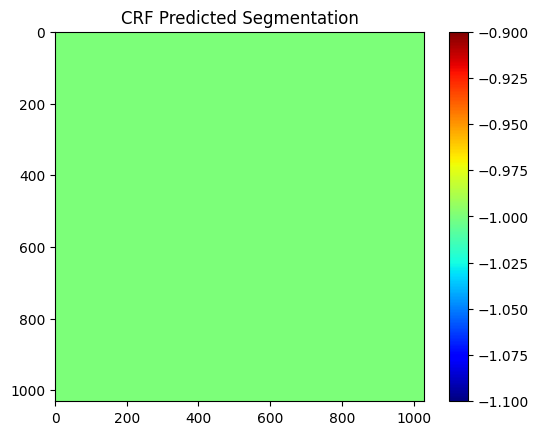

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn_crfsuite import CRF

# Sparse label positions and corresponding labels
sparse_labels = {(int(row['y']), int(row['x'])): row['label_name'] for _, row in quadrat_df.iterrows()}

# Initialize an empty label map
height, width = segments.shape


# Example features for each pixel (color, position, etc.)
def extract_features(image, height, width):
    features = []
    for y in range(height):
        for x in range(width):
            pixel_features = [image[y, x, 0], image[y, x, 1], image[y, x, 2], y, x]  # RGB + coordinates
            features.append(pixel_features)
    return features

# Assuming you have a method to convert labels to numeric
def convert_labels(sparse_labels):
    label_map = {}
    for i, label in enumerate(set(sparse_labels.values())):
        label_map[label] = i
    return label_map

# Extract features and convert labels
features = extract_features(image_rgb, height, width)
label_map = convert_labels(sparse_labels)

# Create a label array for all pixels
y = np.full((height, width), -1)  # Default to -1 (unlabeled)
for (y_coord, x_coord), label in sparse_labels.items():
    y[y_coord, x_coord] = label_map[label]  # Set the label for the sparse positions

# Convert y to a list of lists for CRF
y_list_of_lists = []
for row in y:
    y_list_of_lists.append(row.tolist())  # Convert each row to a list

# Initialize and fit the CRF
crf = CRF(algorithm='lbfgs')

print(features, y_list_of_lists)
crf.fit(features, y_list_of_lists)

# # Predict labels for all pixels
# predicted_labels = crf.predict(features)

# # Reshape predicted labels to match the original image shape
# label_map_reshaped = np.array(predicted_labels).reshape(height, width)

# # Visualize results
# plt.imshow(label_map_reshaped, cmap='jet')
# plt.title('CRF Predicted Segmentation')
# plt.show()


In [107]:
y_list_of_lists[0:10]

[['O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',